# Decision Tree

In [47]:
import numpy as np
import pandas as pd
import imblearn
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
df = pd.read_csv('telecom_churn.csv')

In [48]:
y = df.Churn
X = df.drop("Churn", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=5)

In [49]:
dtc = DecisionTreeClassifier(random_state=5)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=5)

In [50]:
print(classification_report(y_test, dtc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       575
           1       0.64      0.75      0.69        92

    accuracy                           0.91       667
   macro avg       0.80      0.84      0.82       667
weighted avg       0.91      0.91      0.91       667




confusion matrix for tree(max_depth 4) after upsamling:
[[546  29]
 [  9  83]]


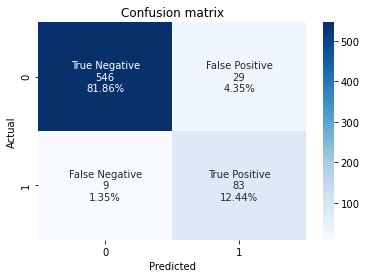

In [51]:
confusion_tree=confusion_matrix(y_test,  best_tuned_clf.predict(X_test))
print("\nconfusion matrix for tree(max_depth 4) after upsamling:\n{}".format(confusion_tree))

group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_tree.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_tree.flatten()/np.sum(confusion_tree)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns_plot = sns.heatmap(confusion_tree, annot=labels, fmt="", cmap='Blues')
sns_plot.set_title("Confusion matrix")
sns_plot.set_xlabel("Predicted")
sns_plot.set_ylabel("Actual")
sns_plot.figure.savefig('images/dt/confusion_matrix_original.jpg')

# Tuning Hyperparameters

In [52]:
cv_method = RepeatedStratifiedKFold(n_splits=10, 
                                    n_repeats=3, 
                                    random_state=5)

In [53]:
df_classifier = DecisionTreeClassifier(random_state=5)

params_DT = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                  'max_features': [1, 2, 3, 4, 5 ,6],
                 'min_samples_split': [2, 3, 4]}

gs_DT = GridSearchCV(estimator=df_classifier, 
                     param_grid=params_DT, 
                     cv=cv_method,
                     n_jobs=-1,
                     verbose=1, 
                     scoring='f1')

gs_DT.fit(X_train, y_train);

Fitting 30 folds for each of 576 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1048 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 9048 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:   18.1s finished


In [54]:
best_tuned_clf = gs_DT.best_estimator_
gs_DT.best_estimator_

DecisionTreeClassifier(max_depth=6, max_features=6, random_state=5)

In [55]:
print(classification_report(y_test, best_tuned_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       575
           1       0.79      0.70      0.74        92

    accuracy                           0.93       667
   macro avg       0.87      0.83      0.85       667
weighted avg       0.93      0.93      0.93       667




confusion matrix for tree(max_depth 4) after upsamling:
[[558  17]
 [ 28  64]]


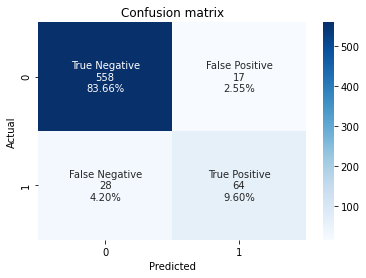

In [56]:
confusion_tree=confusion_matrix(y_test,  best_tuned_clf.predict(X_test))
print("\nconfusion matrix for tree(max_depth 4) after upsamling:\n{}".format(confusion_tree))

group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_tree.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_tree.flatten()/np.sum(confusion_tree)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns_plot = sns.heatmap(confusion_tree, annot=labels, fmt="", cmap='Blues')
sns_plot.set_title("Confusion matrix")
sns_plot.set_xlabel("Predicted")
sns_plot.set_ylabel("Actual")
sns_plot.figure.savefig('images/dt/confusion_matrix_original_tuned.jpg')

# SMOTETomek Resampling

In [57]:
def resample_SMOTE(X_train, y_train, random_state):
    smt = SMOTETomek(sampling_strategy=1.0, random_state=random_state)
    X_smt, y_smt = smt.fit_sample(X, y)

    return X_smt, y_smt

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=5)

X_train, y_train = resample_SMOTE(X_train, y_train, 5)

In [59]:
dtc = DecisionTreeClassifier(random_state=5)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=5)

In [60]:
print(classification_report(y_test, dtc.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       575
           1       0.97      1.00      0.98        92

    accuracy                           1.00       667
   macro avg       0.98      1.00      0.99       667
weighted avg       1.00      1.00      1.00       667




confusion matrix for tree(max_depth 4) after upsamling:
[[572   3]
 [  0  92]]


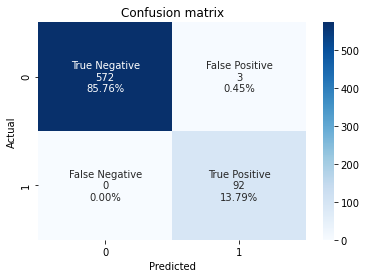

In [67]:
confusion_tree=confusion_matrix(y_test,  dtc.predict(X_test))
print("\nconfusion matrix for tree(max_depth 4) after upsamling:\n{}".format(confusion_tree))

group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_tree.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_tree.flatten()/np.sum(confusion_tree)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns_plot = sns.heatmap(confusion_tree, annot=labels, fmt="", cmap='Blues')
sns_plot.set_title("Confusion matrix")
sns_plot.set_xlabel("Predicted")
sns_plot.set_ylabel("Actual")
sns_plot.figure.savefig('images/dt/confusion_matrix_dt.jpg')

# Tunining Hyperparameters

In [62]:
cv_method = RepeatedStratifiedKFold(n_splits=10, 
                                    n_repeats=3, 
                                    random_state=5)

In [63]:
df_classifier = DecisionTreeClassifier(random_state=5)

params_DT = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                  'max_features': [1, 2, 3, 4, 5 ,6],
                 'min_samples_split': [2, 3, 4]}

gs_DT = GridSearchCV(estimator=df_classifier, 
                     param_grid=params_DT, 
                     cv=cv_method,
                     n_jobs=-1,
                     verbose=1, 
                     scoring='f1')

gs_DT.fit(X_train, y_train);

Fitting 30 folds for each of 576 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 5640 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 11240 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:   19.6s finished


In [64]:
best_tuned_clf = gs_DT.best_estimator_
gs_DT.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features=4,
                       random_state=5)

In [65]:
print(classification_report(y_test, best_tuned_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       575
           1       0.74      0.90      0.81        92

    accuracy                           0.94       667
   macro avg       0.86      0.93      0.89       667
weighted avg       0.95      0.94      0.95       667




confusion matrix for tree(max_depth 4) after upsamling:
[[546  29]
 [  9  83]]


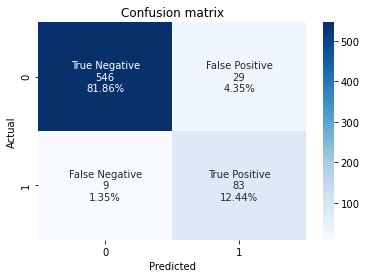

In [66]:
confusion_tree=confusion_matrix(y_test,  best_tuned_clf.predict(X_test))
print("\nconfusion matrix for tree(max_depth 4) after upsamling:\n{}".format(confusion_tree))

group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_tree.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_tree.flatten()/np.sum(confusion_tree)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns_plot = sns.heatmap(confusion_tree, annot=labels, fmt="", cmap='Blues')
sns_plot.set_title("Confusion matrix")
sns_plot.set_xlabel("Predicted")
sns_plot.set_ylabel("Actual")
sns_plot.figure.savefig('images/dt/confusion_matrix_dt_tuned.jpg')